# DELE CA2 (GAN)


### Problem: Singapore Pictures in Van-Gogh Style Paintings
In this problem, we try to emulate Van-Gogh Styled Paintings from Singapore picures. This can be done with various neural networks, which we will be exploring. 

#### Import Libraries

In [90]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import PIL.Image as Image

import tensorflow as tf
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

AUTOTUNE = tf.data.AUTOTUNE

### Data

For our problem, we used the various datasets:

Singapore Pictures: Copyright Free Images from Unsplash (https://unsplash.com/s/photos/singapore)

Van Gogh Pictures: Saint Remy Pictures from Kaggle (https://www.kaggle.com/ipythonx/van-gogh-paintings?select=Saint+Remy)

Let's first load our data

We use half of our data for training. The reason we use a relatively small train set is so that our training does not take too long.

Half the dataset includes ~60-70 Images of each Class

In [91]:
training = tf.keras.preprocessing.image_dataset_from_directory(
  "./Small SG-VG",
  validation_split=0.5,
  subset="training",
  seed=6969,
  image_size=(320, 320),
  batch_size=1)

Found 262 files belonging to 2 classes.
Using 131 files for training.


In [92]:
# Split data by class
vg = training.filter(lambda x, y: tf.reduce_all(tf.not_equal(y, [0])))
sg = training.filter(lambda x, y: tf.reduce_all(tf.not_equal(y, [1])))

This is the Data Augmentation we plan on using for our model. It includes Random copping, Normalizing and Random Jitter.



In [93]:
BUFFER_SIZE = 50
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256 

def random_crop(image):
    cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)
  
    # random mirroring
    image = tf.image.random_flip_left_right(image)
  
    return image  

def preprocess_image_train(image, label):
    image = image[0]
    image = random_jitter(image)
    image = normalize(image)
    return (image, label)

Our Augmentation function is called on our original dataset every epoch so we have varied training images ever epoch

Our data loaded in (320, 320) and reshaped to (286x286) and cropped to (256, 256) and jittered

## CycleGAN

In this implementation, we use the pix2pix model already done by in tensorflow_examples. 

https://www.tensorflow.org/tutorials/generative/pix2pix

https://github.com/tensorflow/examples

This model differs in that it uses a modified **unet** generator instead of the modified **resnet** based generator in the original CycleGAN Paper.

**Note**: We try to implement the resnet based generator in our Extra_ResnetCycleGAN Notebook

In [94]:
!pip install -q git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix

CycleGAN contains 2 pairs of Generators and Discriminators, each pair of GAN learns convert and differentiate between 2 sets of images (in this case Singapore Pictures and Van Gogh Paintings). 

The goal is to train the model to be able to convert an image from one class of images to look like the other by cycling through the models and judging how far the image looks from the original



Let's make the model

In [95]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

We also need the loss function. In this case, CycleGAN wants the image from one class of images to look like the other after cycling through both sets of GANs and judging how far the image looks from the original.

This is in essence our loss function, which we create here.

In [96]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [97]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [98]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [99]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Now that we have everything else, we need to create the train function where we try to minimise the loss function we defined earlier


In [100]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

Let's make a checkpoint so we do not lose our training progress. Colab likes to disconnect sometimes....

In [107]:
checkpoint_path = "./test models"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored: ' + str(ckpt_manager.latest_checkpoint))

Latest checkpoint restored: ./drive/MyDrive/test models/ckpt-2


Finally, we can train our model! Let's define the number of epochs and make a function to generate images so we can watch the progress as we train our model.

In [121]:
EPOCHS = 450

def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

  return [test_input, prediction]

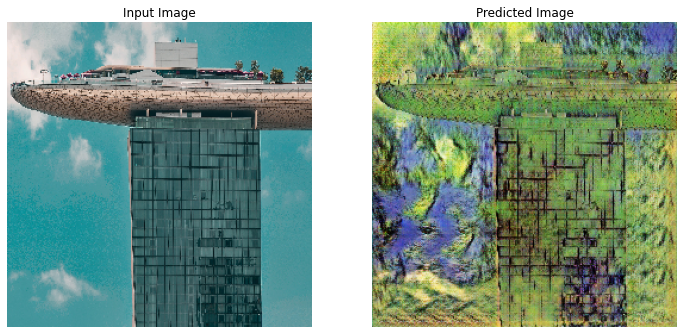

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  re_vg = vg.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

  re_sg = sg.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((re_sg, re_vg)):
    train_step(image_x[0], image_y[0])
    if n % 5 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  generate_images(generator_g, next(iter(re_sg))[0])

  if (epoch + 1) % 100 == 0:   
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

After training for 450 epochs, ~10 hours, our model is looking pretty good! Let's see how it's doing from by using our test dataset to see the results!

In [104]:
test = tf.keras.preprocessing.image_dataset_from_directory(
  "./Small SG-VG",
  validation_split=0.5,
  subset="validation",
  seed=6969,
  batch_size=1)

Found 262 files belonging to 2 classes.
Using 131 files for validation.


In [105]:
sg_test = test.filter(lambda x, y: tf.reduce_all(tf.not_equal(y, [1])))


def preprocess_image_test(image, label):
  image = normalize(image)
  return image

sg_test = sg_test.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

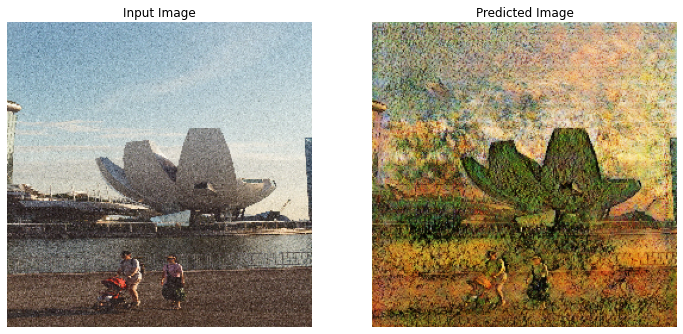

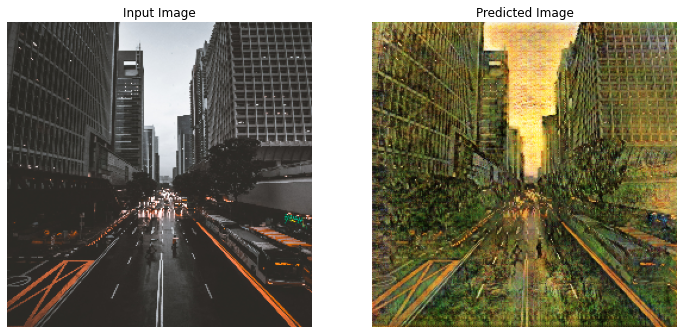

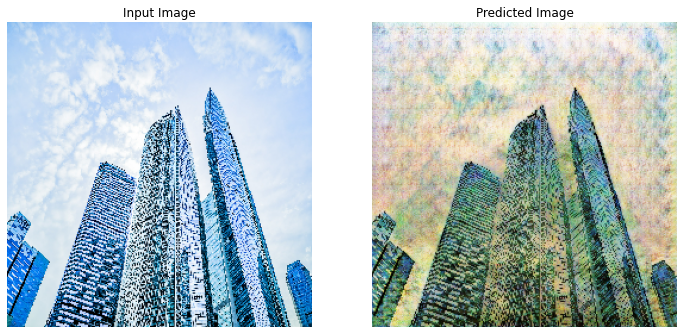

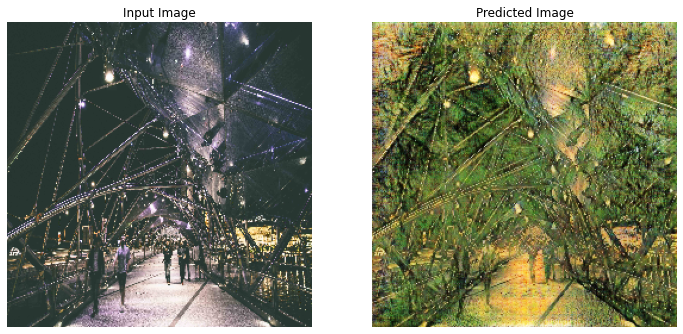

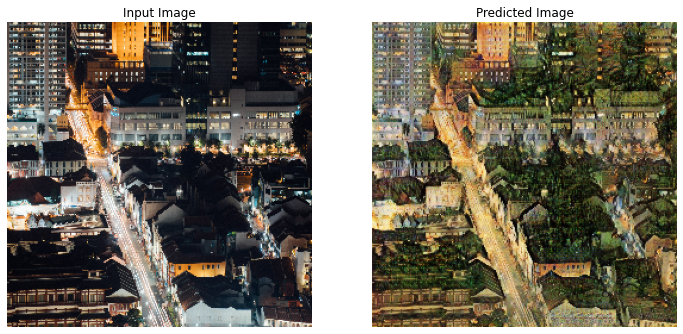

In [139]:
for inp in sg_test.take(5):
  generate_images(generator_g, inp[0]) 

Wow, they look just like Van Gogh's Paintings! They also look mcuh better than the Neural Style Transfer Image we made in Part 1!

I wonder what would happen if we combined them....?

Let's use tensorflow hub's fast neural style transfer to apply it on top of our predicted image and see what it does

In [70]:
# Load TF-Hub module.
import tensorflow_hub as hub
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

styles = [
  '/content/drive/MyDrive/Small SG-VG/VG/Copy of Field with Poppies.jpg',
  '/content/drive/MyDrive/Small SG-VG/VG/Copy of Green Wheat Fields.jpg',
  '/content/drive/MyDrive/Small SG-VG/VG/Copy of Road with Cypress and Star.jpg',
  '/content/drive/MyDrive/Small SG-VG/VG/Copy of Starry Night.jpg'
]

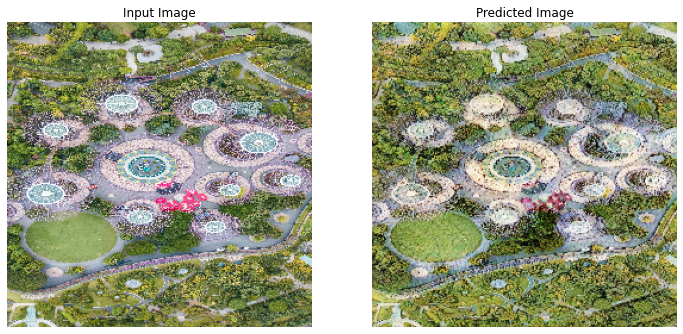

In [142]:
for inp in sg_test.take(1):
  og_pred = generate_images(generator_g, inp[0]) 

We can choose a style image that suits our prediction the most, based on this 4 different styles of Van Gogh Paintings

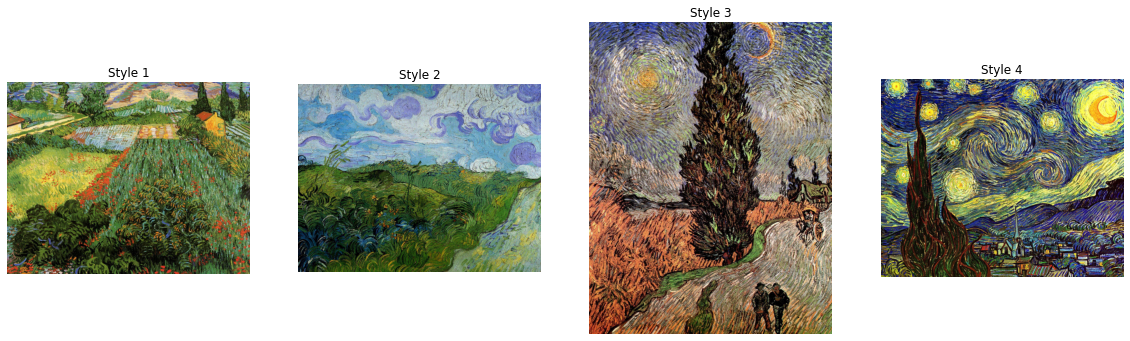

In [78]:
plt.figure(figsize=(20, 10))
for i in range(len(styles)):
  im = Image.open(styles[i])
  plt.subplot(1, 4, i+1)
  plt.title("Style " + str(i+1))
  plt.imshow(im)
  plt.axis('off')
plt.show()

Choose a style: 4


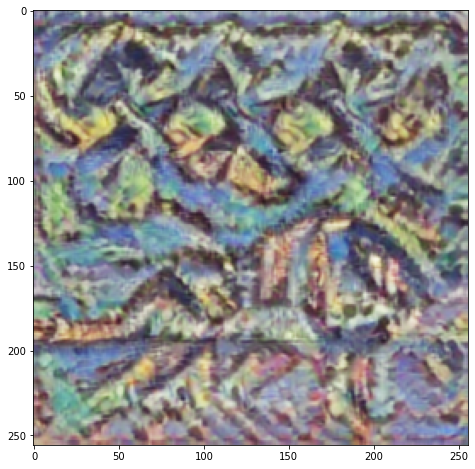

In [141]:
choice = int(input("Choose a style: "))

if choice in [1, 2, 3, 4]:
  plt.figure(figsize=(8,8))
  style = plt.imread(styles[choice-1]).astype(np.float32)[np.newaxis, ...] / 255
  stylized_image = hub_module(tf.constant(og_pred[1]), tf.constant(style))[0]
  plt.imshow(stylized_image[0])

Unfortunately, it doesn't work too well, although it was fun to try. 

Our CycleGAN Still works pretty well though, and is something to be proud of!

## Check out the Extra for Cycle GAN Implementation in Extra_ResnetCycleGAN

## References

https://www.tensorflow.org/tutorials/generative/pix2pix

https://github.com/tensorflow/examples

https://www.tensorflow.org/tutorials/generative/cyclegan#set_up_the_input_pipeline

https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization#specify_the_main_content_image_and_the_style_you_want_to_use

https://machinelearningmastery.com/cyclegan-tutorial-with-keras/

https://github.com/xhujoy/CycleGAN-tensorflow